<a href="https://colab.research.google.com/github/Mahshad-RM/MOR/blob/old/Assignments_AE_Sindy(Part_2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
try:
     from dlroms import*
except:
     !pip install --no-deps git+https://github.com/NicolaRFranco/dlroms.git
     from dlroms import*

import numpy as np

## **Linear elasticity**: material design for a stunt training facility

## Parametric SINDy for Latent Dynamics

To obtain an interpretable model of the reduced dynamics, we use parametric SINDy. It assumes the latent state $z(t)$ evolves as:

$$\partial_t z_\mu = A_\mu \, \Xi(z),$$

where $\Xi(z)$ is a fixed library of nonlinear functions, and $A_\mu$ is a parameter-dependent coefficient matrix predicted by a neural network $\eta(\mu)$.

The network is trained to match the true latent derivatives and promote sparsity, so the final model is both compact and interpretable. This lets us understand how the reduced dynamics change with the floor design parameter $\mu$ (i.e., layer thickness).

In [39]:
# FOM discretization
mesh = fe.unitsquaremesh(40, 40)
Vh = fe.space(mesh, 'CG', 1, vector_valued = True)
clc()

In [40]:
# Dataset (parameters and FOM simulations)
import gdown
gdown.download(id = "1XYPnIpVVc9jkd7LwMhC-FYoV2RTnTK8L", output = "floor.npz")
clc()

data = np.load("floor.npz")
mu, u = dv.tensor(data['mu'], data['u'])

In [41]:
# Auxiliary function for animation
def animated_warp(u, Vh):
  from dlroms.gifs import save as savegif
  rnd = np.random.randint(50000)
  def drawframe(i):
    plt.figure(figsize = (4, 4))
    fe.plot(u[i], Vh, axis = [-0.25, 1.25, -0.25, 1.25], warp = True)
    plt.title("t = %.2f" % (i*0.02))
    plt.axis("off")
  savegif(drawframe, len(u), "temp%d-gif" % rnd)
  from PIL import Image, ImageSequence
  path = "temp%d-gif.gif" % rnd
  with Image.open(path) as im:
    frames = [frame.copy() for frame in ImageSequence.Iterator(im)]
    frames[0].save(path, save_all=True, append_images=frames[1:], loop=0, duration=im.info.get('duration', 100))
  from IPython.display import Image, display
  display(Image("temp%d-gif.gif" % rnd))
  from os import remove
  remove("temp%d-gif.gif" % rnd)

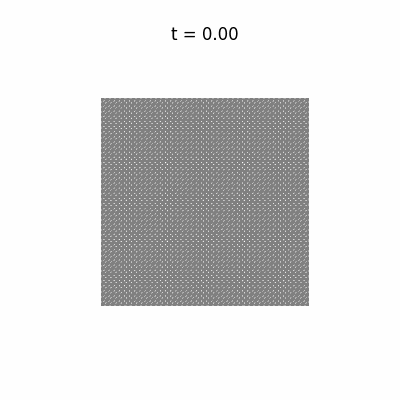

In [42]:
# First simulation in the dataset
animated_warp(u[0], Vh)

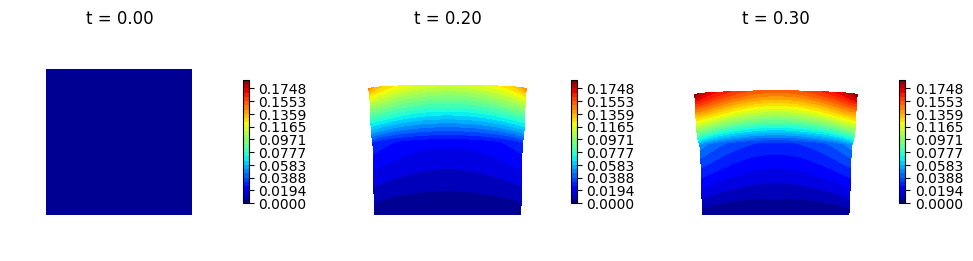

In [43]:
# Fancy plot showing warping and displacement magnitude altogether

which = 7 # First simulation

ns, nt, nh = u.shape
t = list(np.linspace(0, 1, nt))

umod = u[which].reshape(nt, -1, 2).pow(2).sum(axis = -1).sqrt()
plt.figure(figsize = (12, 4))
for i, ti in enumerate([0, 10, 15]):
  plt.subplot(1, 3, i+1)
  warped_mesh = fe.warpmesh(u[which, ti], Vh)
  delta = mu[which].item()
  WVh = fe.space(warped_mesh, 'CG', 1)

  fe.plot(umod[ti], WVh, levels = 30, vmin = umod.min(), vmax = umod.max(), colorbar = True, shrink = 0.4)
  plt.axis([-0.25, 1.25, -0.25, 1.25])
  plt.title("t = %.2f" % t[ti])
  plt.axis("off")

In [44]:
ns, nt, nh = u.shape
p = mu.shape[-1]
print("Trajectories:\t%d." % ns)
print("Timesteps:\t%d." % nt)
print("FOM dimension:\t%d." % nh)
print("Parameters:\t%d." % p)

Trajectories:	100.
Timesteps:	51.
FOM dimension:	3362.
Parameters:	1.


In [45]:
l2 = L2(Vh)
clc()

def error(utrue, upred):
    return (l2(utrue-upred).reshape(-1, nt).sum(axis = -1)/l2(utrue).reshape(-1, nt).sum(axis = -1)).mean()

In [46]:

u = u.reshape(-1, nh)

from torch.optim import Adam
ntrain= 75*nt

latent = 10  # good for starting

# Use nn.Sequential or custom DFNN class
encoder = Dense(nh, 200, gelu) + Dense(200, 100, gelu) + Dense(100, latent, None)
decoder = Dense(latent, 100, gelu) + Dense(100, 200, gelu) + Dense(200, nh, None)

autoencoder = DFNN(encoder + decoder)

autoencoder.He()

autoencoder.train(
    u, u,
    ntrain=ntrain,
    epochs=500,
    loss=mse(l2),
    optim=Adam,
    lr=1e-4,
    batchsize=64
)

autoencoder.freeze()
print("Autoencoder MRE: %s" % num2p(error(u[ntrain:], autoencoder(u[ntrain:]))))

		Train		Test
Epoch 500:	4.40e-08	4.35e-08.

>> ETA: 4.29s.

Training complete. Elapsed time: 35 minutes 42.80 seconds.
Autoencoder MRE: 1.13%


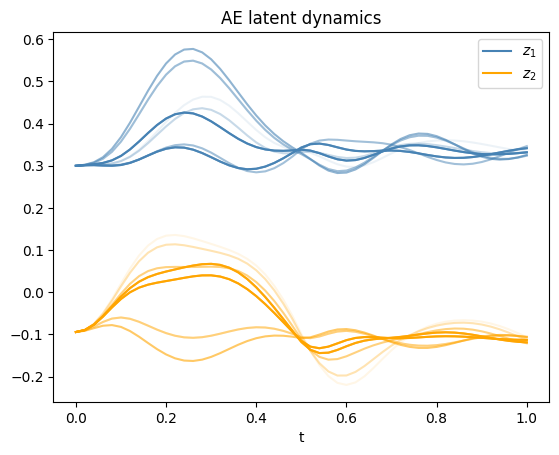

In [47]:
z =  encoder(u) ### <--- latent representation of the solutions
t = np.arange(nt)*2e-2

for i in range(10):
  plot(t, z.reshape(-1, nt, latent)[i][:, 0], color = 'steelblue', alpha = 1.0 - i/10, label = '$z_1$' if i==0 else None)
  plot(t, z.reshape(-1, nt, latent)[i][:, 1], color = 'orange', alpha = 1.0 - i/10, label = '$z_2$' if i==0 else None)

plt.legend()
plt.xlabel("t")
plt.title("AE latent dynamics")
None

In [118]:
from dlroms.dnns import Weightless
from torch import matmul

class Library(Weightless):
  def __init__(self, lib):
    super(Library, self).__init__()
    self.lib = lib

  def forward(self, x):
    from torch import cat
    nx = len(x)
    return cat([f(x).reshape(nx, -1) for f in self.lib], axis = -1)

class SINDy(ROM):
  def __init__(self, *args, **kwargs):
    from torch.nn import Parameter
    super(SINDy, self).__init__(*args, **kwargs)
    self.thr = Parameter(dv.tensor(0.0))

  def threshold(self, A0):
    k = 10.0  # soften from 100
    return A0 * torch.sigmoid(k * (torch.abs(A0) - self.thr))


  def A(self, mu):
    eta = self[0]
    A0 = eta(mu)
    return self.threshold(A0)

  def forward(self, mu, z):
    A = self.A(mu)
    theta = self.Xi(z).unsqueeze(-1)
    return matmul(A, theta).squeeze(-1), A

  def freeze(self, *args, **kwargs):
    super(SINDy, self).freeze(*args, **kwargs)
    self.thr.requires_grad_(False)

  def unfreeze(self, *args, **kwargs):
    super(SINDy, self).freeze(*args, **kwargs)
    self.thr.requires_grad_(True)

  def evolve(self, mu0, z0, steps, tau):
    from torch import atleast_2d
    mu0s = atleast_2d(mu0)
    z0s = atleast_2d(z0)

    many, n = z0s.shape
    zsindy = self.coretype().zeros(many, steps + 1, n)
    zsindy[:, 0] = z0s
    for j in range(steps):
      dzdtj = self.forward(mu0s, zsindy[:, j])[0]
      zsindy[:, j+1] = zsindy[:, j] + tau*dzdtj

    return zsindy

  def parameters(self, *args, **kwargs):
    return super(SINDy, self).parameters() + [self.thr]

  def He(self, *args, **kwargs):
    from torch.nn import Parameter
    super(SINDy, self).He(*args, **kwargs)
    self.thr = Parameter(dv.tensor(0.0))

<font color= '#orange'>Finite Difference Approximation of Time Derivatives:

In [119]:
def dt(zval):
  """Approximation of time derivatives via finite differences.
  Later used in the definition of the loss to approximate the true derivatives."""
  tau = 2e-2
  zprev = zval.reshape(-1, nt, latent)[:, :-2, :].reshape(-1, latent)
  znext = zval.reshape(-1, nt, latent)[:, 2: ,  :].reshape(-1, latent) ### <--- latent state at time instant "i+1", for each sample in the batch
  dzdt = (znext-zprev)/(2*tau)
  return dzdt




**Purpose:** Approximates the time derivative $\frac{dz}{dt}$ using central differences.

**Explanation:**

Suppose $z(t) \in \mathbb{R}^r$ is the latent trajectory, known at discrete time points $t_0, t_1, \ldots, t_{N_t-1}$, spaced by $\tau = 0.02$.

Then, for each latent variable $z_j(t)$, its time derivative at time $t_i$ is approximated by:

$$\frac{dz_j}{dt}\Big|_{t_i} \approx \frac{z_j(t_{i+1}) - z_j(t_{i-1})}{2\tau}$$

<font color= '#orange'>  Defining the SINDy Library $\boldsymbol{\Xi}(\mathbf{z})$

In [126]:
from dlroms.dnns import Reshape
import torch # Import torch here

Xi = Library([
    lambda x: x,
    lambda x: x**2,
    lambda x: x[:,0]*x[:,1],
    lambda x: x**3,
    lambda x: torch.sin(x),
    lambda x: torch.exp(-x**2),  # example of richer dynamics
    lambda x: 1.0 + 0*x
])



This defines the library of candidate nonlinear functions $\boldsymbol{\Xi}(\mathbf{z})$, used to express the latent dynamics. If $\mathbf{z} \in \mathbb{R}^r$, then each function outputs $\mathbb{R}^m$, and so:

$$\boldsymbol{\Xi}(\mathbf{z}) = [z_1, \ldots, z_r, z_1^2, \ldots, z_r^2, z_1z_2, z_1^3, \ldots, z_r^3, 1] \in \mathbb{R}^m$$

<font color= '#orange'> Parameter-to-Coefficient Neural Network $\eta(\mu)$

In [127]:
m = Xi(dv.zeros(1, latent)).shape[-1]
p = mu.shape[-1]

eta = Dense(p, 50, gelu) + Dense(50, 50, gelu) + Dense(50, m*latent, None) + Reshape(latent, m)


In [122]:
with torch.no_grad():
    sample_mu = mu[:5]  # Take first 5 mu values for inspection
    eta_output = eta(sample_mu)  # This has shape [5, latent * m]
    max_val = eta_output.abs().max().item()
    mean_val = eta_output.abs().mean().item()
    print(f"[Diagnostic] eta(mu) abs max: {max_val:.6f}, mean: {mean_val:.6f}")


[Diagnostic] eta(mu) abs max: 0.313684, mean: 0.084406


This defines a neural network:

$$\eta: \mathbb{R}^p \longrightarrow \mathbb{R}^{r \times m}$$

where:

* $p$: number of parameters (e.g., $\mu$, the layer thickness).
* $r$: dimension of latent space (number of components in $z$).
* $m$: number of terms in the library $\Xi(z)$.

The output of the network is reshaped to be a matrix $A_\mu \in \mathbb{R}^{r \times m}$, which encodes the coefficients of the dynamics for a specific parameter $\mu$.

<font color= '#orange'> Defining the Parametric SINDy Model

In [130]:


class ScaledEta(nn.Module):
    def __init__(self, net, scale):
        super().__init__()
        self.net = net
        self.scale = scale

    def forward(self, mu):
        return self.scale * self.net(mu)

scaled_eta = ScaledEta(eta, scale=10.0)
sindy = SINDy(eta, Xi=Xi)

sindy.He()

In [131]:
print(scaled_eta)

ScaledEta(
  (net): Consecutive(
    (0): Dense(
      (lin): Linear(in_features=1, out_features=50, bias=True)
    )
    (1): Dense(
      (lin): Linear(in_features=50, out_features=50, bias=True)
    )
    (2): Dense(
      (rho): Identity()
      (lin): Linear(in_features=50, out_features=610, bias=True)
    )
    (3): Reshape(
      (rho): None
    )
  )
)


This builds the parametric SINDy model:

$$\frac{dz}{dt} = A_\mu \Xi(z) \quad \text{where} \quad A_\mu = \eta(\mu)$$

The loss function used during training will:

* Minimize the MSE (Mean Squared Error) between $A_\mu \Xi(z)$ and the true time derivative $\partial_t z$.
* Encourage sparsity in $A_\mu$, so that most coefficients are near zero.

In [107]:
print("mu shape:", mu.shape)
print("z shape:", z.shape)


mu shape: torch.Size([100, 1])
z shape: torch.Size([5100, 10])


In [137]:
def sindy_loss(ztrue, sindy_output):
  dzpred, A = sindy_output
  dzdt_true = dt(ztrue)
  return ((dzdt_true - dzpred.reshape(-1, nt, latent)[:, 1:-1].reshape(-1, latent))**2).mean()

def sindy_error(ztrue, sindy_output):
  dzpred, A = sindy_output
  dzdt_true = dt(ztrue) ### <-- time derivatives of the true latent coordinates
  return mse(euclidean)(dzdt_true, dzpred.reshape(-1, nt, latent)[:, 1:-1].reshape(-1, latent))
def unfreeze(self, *args, **kwargs):
    super(SINDy, self).unfreeze(*args, **kwargs)  # should be unfreeze not freeze!
    self.thr.requires_grad_(True)
unfreeze_model(sindy)

mu_repeated = (dv.zeros(ns, nt, 1) + mu.reshape(ns, 1, -1)).reshape(ns*nt, -1) ### <--- transforming [mu0, mu1, mu2, ...] onto [mu0, .., mu0, mu1, ... mu1, mu2, ....] for shape consistency with z
sindy.train((mu_repeated, z), z, loss = sindy_loss, error = sindy_error, epochs = 50, ntrain = ntrain)
sindy.train((mu_repeated, z), z, loss = sindy_loss, error = sindy_error, epochs = 500, ntrain = ntrain)



		Train		Test
Epoch 500:	3.03e+01	2.87e+01.

>> ETA: 0.08s.

Training complete. Elapsed time: 40.25 seconds.


In [139]:
print("AE MRE: %s" % num2p(error(u[ntrain:], ae(u[ntrain:]))))
print("AE + SINDy MRE: %s" % num2p(error(u[ntrain:], decoder(zsindy.reshape(ns*nt, -1)[ntrain:])))) ### <--- AE + SINDy approximations obtained by decoding sindy evolved states

AE MRE: 10.29%
AE + SINDy MRE: 100.00%


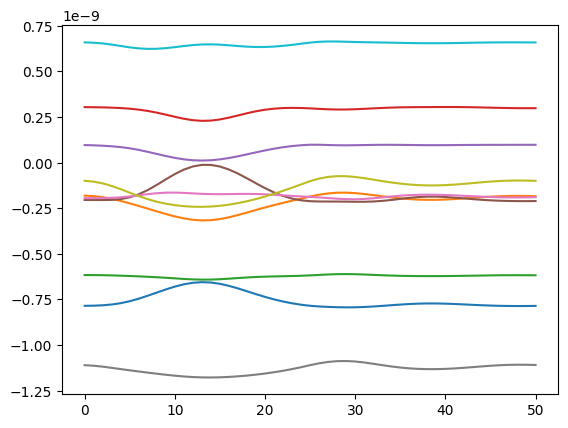

In [141]:
dz_pred, _ = sindy(mu_repeated[:nt], z[:nt])
plt.plot(dz_pred.detach().numpy())


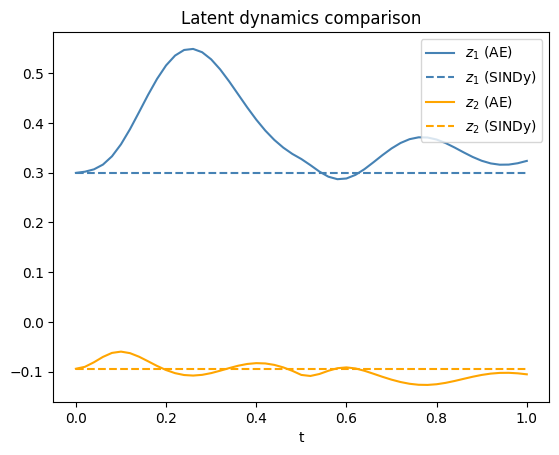

In [134]:
sindy.freeze()

ztrue = encoder(u).reshape(-1, nt, latent)
z0s = ztrue[:, 0]
zsindy = sindy.evolve(mu_repeated.reshape(ns, nt, -1)[:, 0], z0s, steps = nt-1, tau = 2e-2)

which = 6
plot(t, ztrue[which, :, 0], color = 'steelblue', label = '$z_1$ (AE)')
plot(t, zsindy[which, :, 0], '--', color = 'steelblue', label = '$z_1$ (SINDy)')
plot(t, ztrue[which, :, 1], color = 'orange', label = '$z_2$ (AE)')
plot(t, zsindy[which, :, 1], '--', color = 'orange', label = '$z_2$ (SINDy)')
plt.legend()
plt.xlabel("t")
plt.title("Latent dynamics comparison")
None